In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
!ls ../data

budapest_connectome_3.0_168_0_median_20k_40.csv
budapest_connectome_3.0_168_0_median_fc_20k_40.csv
budapest_connectome_3.0_209_0_median.graphml
budapest_connectome_3.0_209_0_median_20k.csv
budapest_connectome_3.0_209_0_median_fc_20k.csv
budapest_connectome_3.0_238_0_median_1m.csv
budapest_connectome_3.0_238_0_median_fc_1m.csv
budapest_connectome_3.0_239_0_median_200k.csv
budapest_connectome_3.0_239_0_median_fc_200k.csv
budapest_connectome_3.0_5_0.148_median_20k_1.csv
budapest_connectome_3.0_5_0.148_median_fc_20k_1.csv
budapest_connectome_3.0_5_0_median_20k_1.csv
budapest_connectome_3.0_5_0_median_fc_20k_1.csv


In [8]:
def calculate_total_nodes(data, col_node_1, col_node_2):
    print(f"# Rows:{len(data)}")
    nodes = np.append(data[col_node_1], data[col_node_2])
    nodes.flatten()
    nodes = set(nodes)
    num_nodes = len(nodes)

    print(f"#:{num_nodes},Max:{max(nodes)}")


In [71]:
# Load the data from the provided CSV file
default_connectivity_file_path = f'../data/budapest_connectome_3.0_5_0_median_default.csv'
df = pd.read_csv(default_connectivity_file_path, delimiter=';')

In [78]:
df.head()

,id node1,id node2,name node1,name node2,parent id node1,parent id node2,parent name node1,parent name node2,edge confidence,edge weight(med nofperflm)
0,559,559,lh.rostralmiddlefrontal_15,lh.rostralmiddlefrontal_15,48,48,ctx-lh-rostralmiddlefrontal,ctx-lh-rostralmiddlefrontal,16,0.075758
1,559,565,lh.rostralmiddlefrontal_15,lh.rostralmiddlefrontal_22,48,48,ctx-lh-rostralmiddlefrontal,ctx-lh-rostralmiddlefrontal,58,0.096154
2,559,560,lh.rostralmiddlefrontal_15,lh.rostralmiddlefrontal_13,48,48,ctx-lh-rostralmiddlefrontal,ctx-lh-rostralmiddlefrontal,53,0.094340
3,559,1004,lh.rostralmiddlefrontal_15,lh.insula_4,48,75,ctx-lh-rostralmiddlefrontal,ctx-lh-insula,35,0.062500
4,559,580,lh.rostralmiddlefrontal_15,lh.rostralmiddlefrontal_3,48,48,ctx-lh-rostralmiddlefrontal,ctx-lh-rostralmiddlefrontal,10,0.022936


In [79]:
df_agg = df.groupby(["parent id node1", "parent id node2"])["edge weight(med nofperflm)"].agg(["count", "mean"]).reset_index()
df_agg.head()

,parent id node1,parent id node2,count,mean
0,1,1,126,0.082420
1,1,2,33,0.085239
2,1,3,8,0.078069
3,1,4,104,0.080515
4,1,5,72,0.076392


In [80]:
def calculate_nodes_and_edges(data, col1, col2):
    # Extract the necessary information
    nodes = np.union1d(data[col1].values, data[col2].values)
    num_nodes = len(nodes)
    edges = set(zip(data[col1], data[col2]))

    print(f"# nodes:{num_nodes}, # edges:{len(edges)}")
    return nodes, num_nodes

In [81]:
_, _ = calculate_nodes_and_edges(df, "parent id node1", "parent id node2")
nodes, num_nodes = calculate_nodes_and_edges(df_agg, "parent id node1", "parent id node2")

# nodes:83, # edges:1211
# nodes:83, # edges:1211


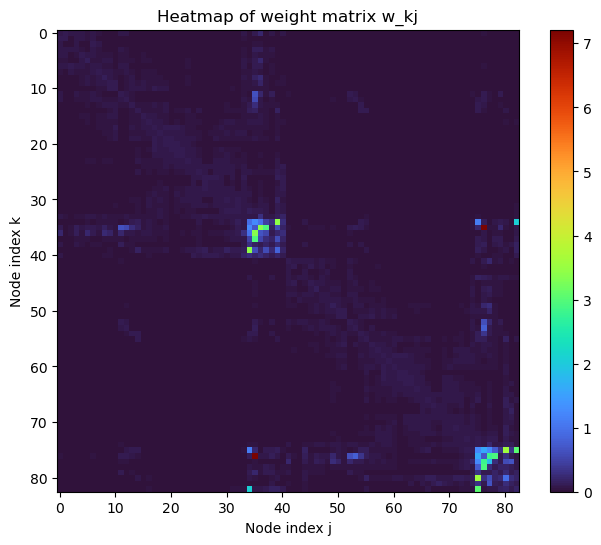

In [82]:
# Create a mapping from node ID to index
node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

w_kj = np.zeros((num_nodes, num_nodes))
        

for _, row in df_agg.iterrows():
    idx1 = node_to_index[row['parent id node1']]
    idx2 = node_to_index[row['parent id node2']]
    weight = row['mean']
    w_kj[idx1, idx2] = weight
    w_kj[idx2, idx1] = weight

# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

### Taking fiber count / fiber length both separetly to calculate electrical connectivity

In [83]:
count_file_path = f'../data/budapest_connectome_3.0_209_0_median_fc_20k.csv'
length_file_path = f'../data/budapest_connectome_3.0_209_0_median_20k.csv'

df_count = pd.read_csv(count_file_path, delimiter=';')
df_len = pd.read_csv(length_file_path, delimiter=';')

print("Nodes")
calculate_total_nodes(df_count, "id node1", "id node2")
calculate_total_nodes(df_count, "parent id node1", "parent id node2")

print("\nParent Nodes")
calculate_total_nodes(df_len, "id node1", "id node2")
calculate_total_nodes(df_len, "parent id node1", "parent id node2")

# df_count.head()
# df_len.head()


Nodes
# Rows:1000
#:480,Max:1015
# Rows:1000
#:76,Max:83

Parent Nodes
# Rows:1000
#:480,Max:1015
# Rows:1000
#:76,Max:83


In [120]:
df_count_agg = df_count.groupby(["parent id node1", "parent id node2"]).agg({
    'edge weight(med nof)': ['mean', 'count']
    }).reset_index()
df_count_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_count_agg.columns.values]

df_len_agg = df_len.groupby(["parent id node1", "parent id node2"]).agg({
    'edge weight(med flm)': ['mean', 'count']
    }).reset_index()
df_len_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_len_agg.columns.values]

df_merged = pd.merge(df_count_agg, df_len_agg, how='inner',
                     left_on=['parent id node1', 'parent id node2'],
                     right_on=['parent id node1', 'parent id node2'])

df_merged = df_merged[['parent id node1', 'parent id node2', 'edge weight(med nof)_mean', 'edge weight(med flm)_mean', 'edge weight(med nof)_count', 'edge weight(med flm)_count']]
df_merged = df_merged.rename(columns={'parent id node1':'node1', 'parent id node2':'node2',
                                       'edge weight(med nof)_mean':'fiber_count', 'edge weight(med flm)_mean':'fiber_length',
                                       'edge weight(med nof)_count':'count_fiber_count', 'edge weight(med flm)_count':'count_fiber_length'})
df_merged.head()

,node1,node2,fiber_count,fiber_length,count_fiber_count,count_fiber_length
0,1,1,2.200000,18.425334,5,5
1,1,4,2.000000,12.600004,1,1
2,1,5,2.333333,18.033689,9,9
3,1,7,2.900000,19.096441,5,5
4,1,8,3.000000,15.735717,1,1


In [121]:
len(df_merged)

311

In [122]:
l = df_merged["node1"].astype('int')
max(l)

83

In [123]:
# Extract the necessary information
nodes = np.union1d(df_merged['node1'].values, df_merged['node2'].values)
num_nodes = len(nodes)
edges = set(zip(df_merged['node1'], df_merged['node2']))

print(f"# nodes:{num_nodes}, # edges:{len(edges)}")

# nodes:76, # edges:311


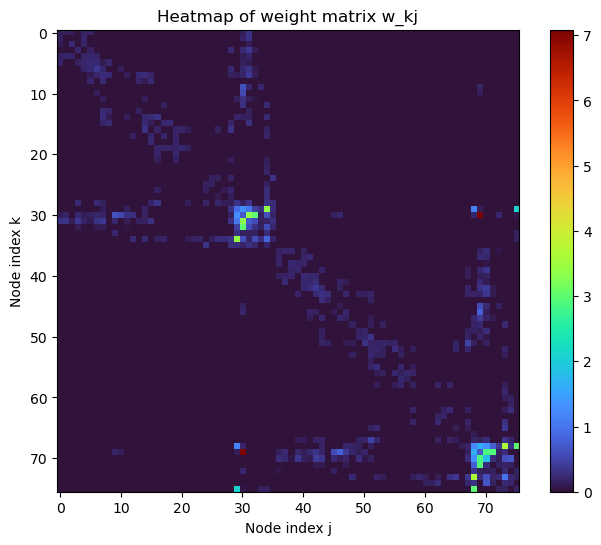

In [125]:
# Create a mapping from node ID to index
node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

w_kj = np.zeros((num_nodes, num_nodes))
        

for _, row in df_merged.iterrows():
    idx1 = node_to_index[row['node1']]
    idx2 = node_to_index[row['node2']]
    weight = row['fiber_count']/row['fiber_length']
    w_kj[idx1, idx2] = weight
    w_kj[idx2, idx1] = weight

# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [90]:
def plot_connectivity(count_file_path, length_file_path):
    df_count = pd.read_csv(count_file_path, delimiter=';')
    df_len = pd.read_csv(length_file_path, delimiter=';')

    print("Original:")
    calculate_nodes_and_edges(df_count, "id node1", "id node2")

    df_merged = pd.merge(df_count, df_len, how='inner',
                     left_on=['parent id node1', 'parent id node2'],
                     right_on=['parent id node1', 'parent id node2'])

    df_merged = df_merged[['parent id node1', 'parent id node2', 'edge weight(med nof)', 'edge weight(med flm)']]
    df_merged = df_merged.rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med nof)':'fiber_count', 'edge weight(med flm)':'fiber_length'})

    l = df_merged["node1"].astype('int')
    print(f"Max node id{max(l)}")

    # Extract the necessary information
    nodes = np.union1d(df_merged['node1'].values, df_merged['node2'].values)
    num_nodes = len(nodes)
    edges = set(zip(df_merged['node1'], df_merged['node2']))

    print(f"# nodes:{num_nodes}, # edges:{len(edges)}")
    print(f"After Mapping to parent:")
    calculate_nodes_and_edges(df_merged, "node1", "node2")

    df_merged_agg = df_merged.groupby(['node1', 'node2']).agg({
        'fiber_count': ['mean', 'count'],
        'fiber_length': ['mean', 'count']
    }).reset_index()

    # Flatten the multi-level column index
    df_merged_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_merged_agg.columns.values]

    # Create a mapping from node ID to index
    node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

    w_kj = np.zeros((num_nodes, num_nodes))

    for _, row in df_merged_agg.iterrows():
        idx1 = node_to_index[row['node1']]
        idx2 = node_to_index[row['node2']]
        weight = row['fiber_count_mean']/row['fiber_length_mean']
        w_kj[idx1, idx2] = weight
        w_kj[idx2, idx1] = weight

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(w_kj, cmap='turbo')
    plt.colorbar(heatmap)
    plt.title('Heatmap of weight matrix w_kj')
    plt.xlabel('Node index j')
    plt.ylabel('Node index k')
    plt.show()

## Varying fibres launched

Original:
# nodes:480, # edges:1000
Max node id83
# nodes:76, # edges:311
After Mapping to parent:
# nodes:76, # edges:311


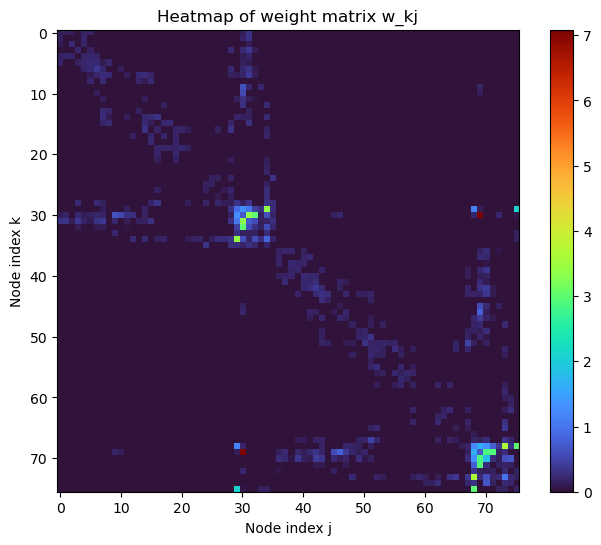

Original:
# nodes:798, # edges:4381
Max node id83
# nodes:81, # edges:537
After Mapping to parent:
# nodes:81, # edges:537


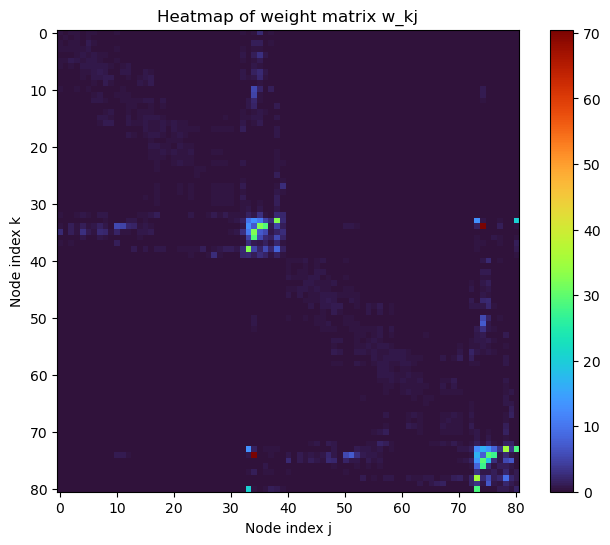

Original:
# nodes:912, # edges:7363
Max node id83
# nodes:81, # edges:618
After Mapping to parent:
# nodes:81, # edges:618


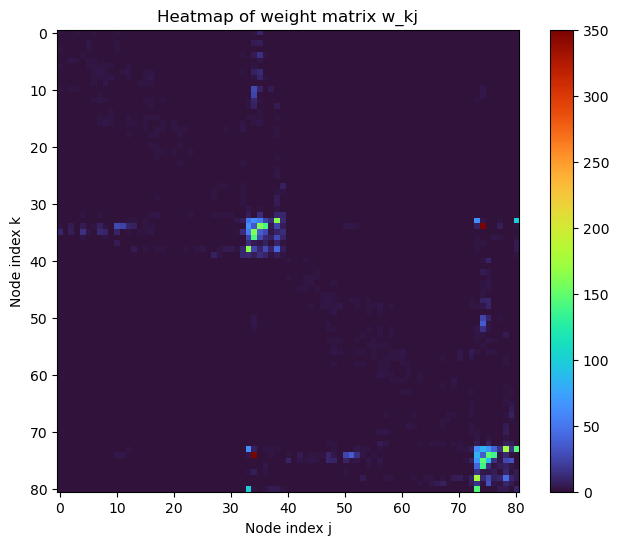

In [91]:
fibres_launched = {'20k': 209, '200k': 239, '1m': 238}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## varying edge confidence

Original:
# nodes:480, # edges:1000
Max node id83
# nodes:76, # edges:311
After Mapping to parent:
# nodes:76, # edges:311


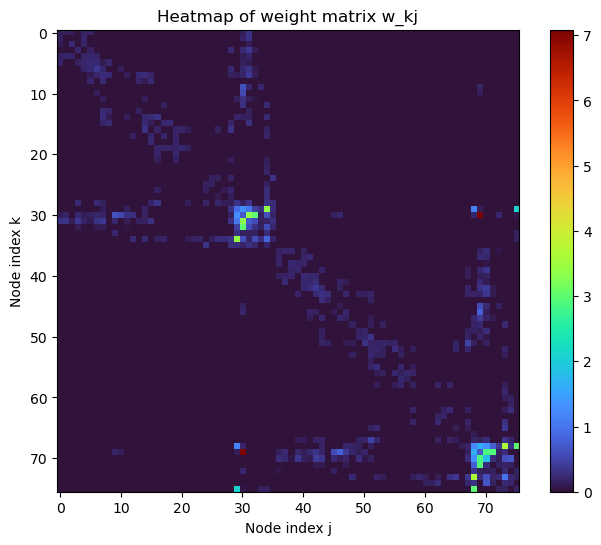

Original:
# nodes:598, # edges:1742
Max node id83
# nodes:78, # edges:399
After Mapping to parent:
# nodes:78, # edges:399


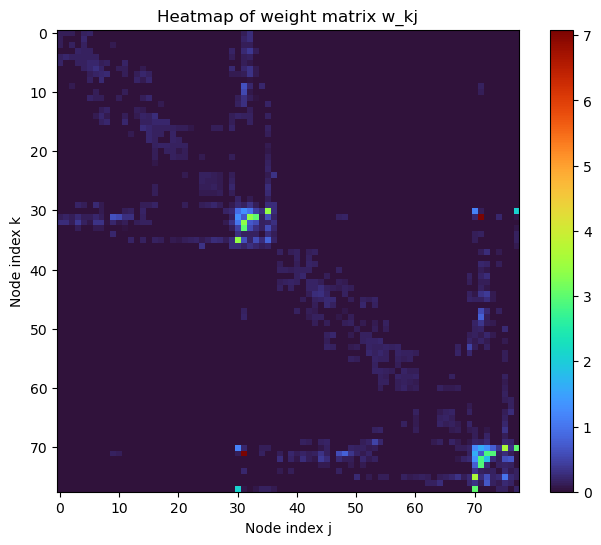

Original:
# nodes:1015, # edges:37477
Max node id83
# nodes:83, # edges:1211
After Mapping to parent:
# nodes:83, # edges:1211


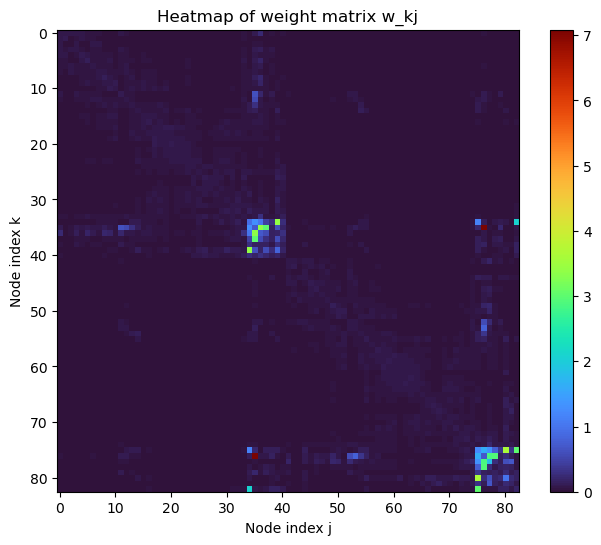

In [92]:
fibres_launched = {'20k': 209, '20k_40': 168, '20k_1':5}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## Varying edge weight

Original:
# nodes:1015, # edges:37477
Max node id83
# nodes:83, # edges:1211
After Mapping to parent:
# nodes:83, # edges:1211


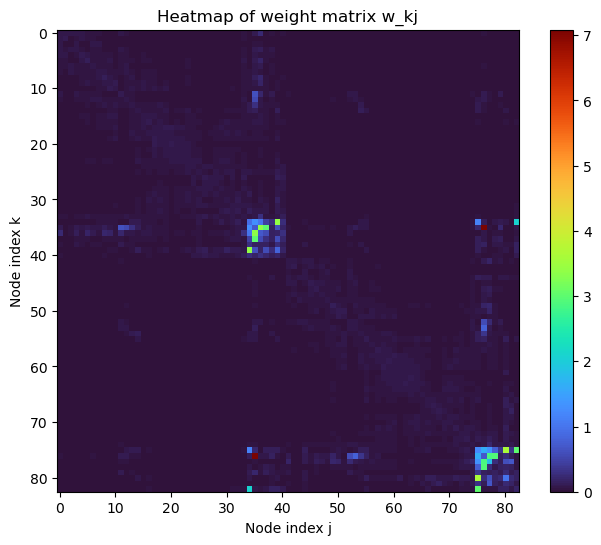

In [93]:
fibres_launched = {'20k_1':0.148}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_5_{value}_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_5_{value}_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## Author's data (mail)

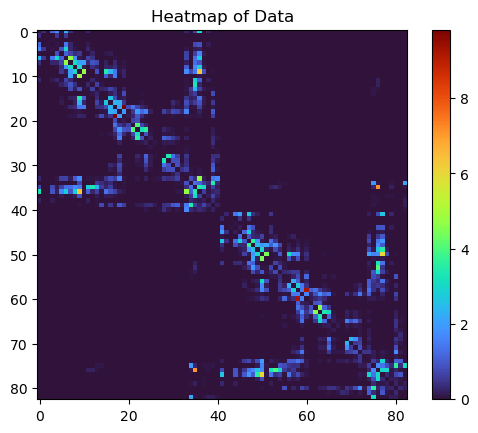

In [11]:
filename = "../author_data/WeightedA33.dat"

data = np.loadtxt(filename)

# Plot the heatmap using matplotlib
plt.imshow(data, cmap='turbo', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of Data')
plt.show()
# Plotting the heatmap
# plt.figure(figsize=(8, 6))
# heatmap = plt.imshow(data, cmap='turbo')
# plt.colorbar(heatmap)
# plt.title('Heatmap of weight matrix w_kj')
# plt.xlabel('Node index j')
# plt.ylabel('Node index k')
# plt.show()

## Resting state dynamics

In [94]:
! ls data

ls: data: No such file or directory


In [95]:
file_path = f'../data/budapest_connectome_3.0_209_0_median_20k.csv'
data = pd.read_csv(file_path, delimiter=';').rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med flm)':'fiber_length'})
data.head()

,id node1,id node2,name node1,name node2,node1,node2,parent name node1,parent name node2,edge confidence,fiber_length
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,22.239342
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,18.400002
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,18.400001
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,17.400008
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,22.000011


In [96]:
# Extract the necessary information
nodes = np.union1d(data['node1'].values, data['node2'].values)
num_nodes = len(nodes)
edges = list(zip(data['node1'], data['node2']))
print(num_nodes, len(edges))

w_kj = np.zeros((num_nodes, num_nodes))

# Create a mapping from node ID to index
node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

for _, row in data.iterrows():
    idx1 = node_to_index[row['node1']]
    idx2 = node_to_index[row['node2']]
    weight = row['fiber_length']
    w_kj[idx1, idx2] = weight
    w_kj[idx2, idx1] = weight

76 1000


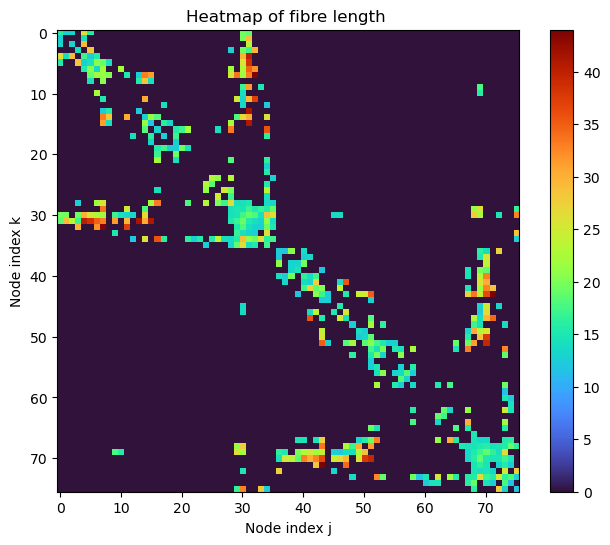

In [97]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of fibre length ')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

### Calculation and Discretisation of the delays

<Axes: xlabel='delay', ylabel='Density'>

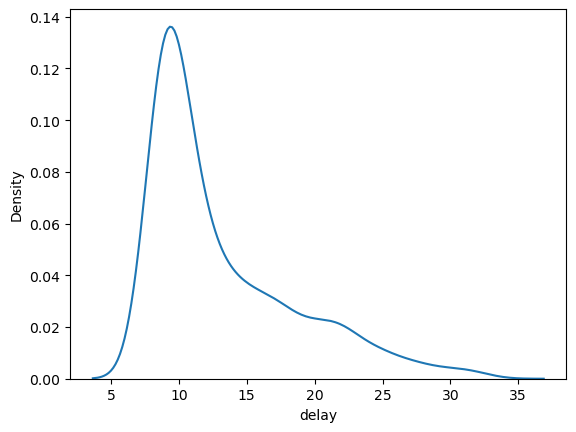

In [98]:
data['delay'] = data['fiber_length'] / 1.5
sns.kdeplot(data, x="delay")

In [99]:
data['delay_discrete'] = pd.cut(data['delay'], bins=40, labels=False)
data.head()

,id node1,id node2,name node1,name node2,node1,node2,parent name node1,parent name node2,edge confidence,fiber_length,delay,delay_discrete
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,22.239342,14.826228,11
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,18.400002,12.266668,7
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,18.400001,12.266667,7
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,17.400008,11.600005,6
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,22.000011,14.666674,11


![alt text](image.png)

In [14]:
# Parameter dictionary
pars = {
    'lambda': -0.01,   # Decay
    'mean_omega': 40.0,       # Mean of the intrinsic frequency
    'variance_omega': 0.1,   # Variance of the intrinsic frequency noise
    'alpha': 1.0,    # Steepness of the sigmoidal function
    'dt': 0.01,      # Time step
    'T': 10.0,       # Total time
    'initial_X': 0.5,  # Some small initial condition for X
    'initial_Y': 0.5,  # Some small initial condition for Y
    'k': 10        # Coupling gain
}
num_nodes=83

In [15]:
# Update the rest of the code to use the pars dictionary
times = np.arange(0, pars['T'], pars['dt'])

np.random.seed(0)  # for reproducibility

# Random omega noise for each node
omega_noise = pars['mean_omega']+np.random.normal(0, np.sqrt(pars['variance_omega']), num_nodes)
print(omega_noise.shape)

lamda_val = args=pars['lambda']

# Initialize the state variables
X = np.zeros((len(times), num_nodes))
Y = np.zeros((len(times), num_nodes))
X[0, :] = np.random.rand(num_nodes)  # Initial condition for X
Y[0, :] = np.random.rand(num_nodes)  # Initial condition for Y


(83,)


In [16]:
# Sigmoidal function F
def S(Z):
    return 1 / (1 + np.exp(-pars['alpha'] * Z))

# Differential equations for the uncoupled system
def dXdt(X, Y, lamda_val, omega_noise):
    # coupling_sum = + pars['k']*S(w_kj*X - data['delay'])
    return lamda_val * X - omega_noise * Y - X * (X**2 + Y**2) 

def dYdt(X, Y, lamda_val, omega_noise):
    return lamda_val * Y + omega_noise * X - Y * (X**2 + Y**2)

def model(y, t):    
    x_0 = y[:num_nodes]
    y_0 = y[num_nodes:2*num_nodes]

    dx_dt = dXdt(x_0, y_0, lamda_val, omega_noise)
    dy_dt = dYdt(x_0, y_0, lamda_val, omega_noise)
    
    # Merge them back into a flat array
    dydt = np.concatenate((dx_dt, dy_dt))
    return dydt


In [18]:
# Set the time points
t = np.linspace(0, 10, 1000) # From 0 to 30 years, a total of 1000 time points

# Set initial conditions
y0 = np.concatenate((X[0,:], Y[0,:]))

# Without coupling
sol_no_coup = odeint(model, y0, t)

x_t = sol_no_coup[:, :num_nodes]
y_t = sol_no_coup[:, num_nodes:2*num_nodes]

Plotted for node 5

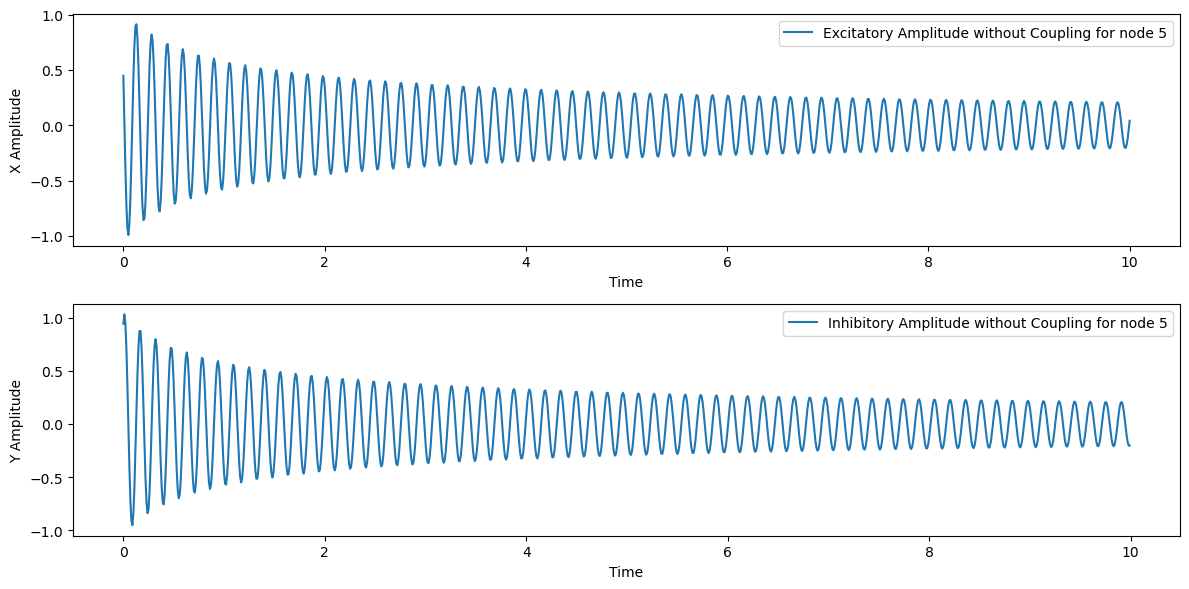

In [21]:
# Plot the results with coupling
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, x_t[:,4], label='Excitatory Amplitude without Coupling for node 5')
plt.xlabel('Time')
plt.ylabel('X Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, y_t[:,4], label='Inhibitory Amplitude without Coupling for node 5')
plt.xlabel('Time')
plt.ylabel('Y Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [106]:
!pip install ddeint

Computing for d=0.00
Computing for d=0.20


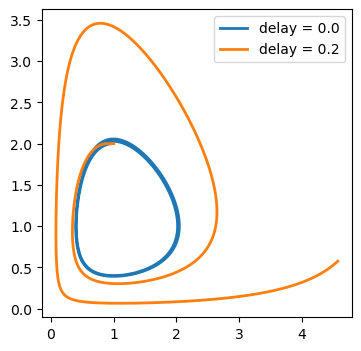

In [107]:
from pylab import array, linspace, subplots
from ddeint import ddeint

# We solve the following system:
# X(t) = 1 (t < 0)
# Y(t) = 2 (t < 0)
# dX/dt = X * (1 - Y(t-d)) / 2
# dY/dt = -Y * (1 - X(t-d)) / 2


def model(Y, t, d):
    x, y = Y(t)
    xd, yd = Y(t - d)
    return array([0.5 * x * (1 - yd), -0.5 * y * (1 - xd)])


g = lambda t: array([1, 2])
tt = linspace(2, 30, 20000)

fig, ax = subplots(1, figsize=(4, 4))

for d in [0, 0.2]:
    print("Computing for d=%.02f" % d)
    yy = ddeint(model, g, tt, fargs=(d,))
    # WE PLOT X AGAINST Y
    ax.plot(yy[:, 0], yy[:, 1], lw=2, label="delay = %.01f" % d)
    ax.legend()

ax.figure.savefig("lotka.jpeg")

In [108]:
num_nodes = 76
w_kj = np.ones((num_nodes, num_nodes))

d = np.arange(0, num_nodes, 1)
xd = np.zeros((d.shape[0], num_nodes))
for i in range(d.shape[0]):
    xd[i,:] = np.ones(num_nodes)*i 

np.sum(np.dot(w_kj, xd), axis=0).shape

(76,)

In [109]:
# Sigmoidal function F
def S(Z):
    return 1 / (1 + np.exp(-pars['alpha'] * Z))

# Differential equations for the uncoupled system
def dXdt(X, Y, lamda_val, omega_noise, xd):
    # coupling_sum = + pars['k']*S(w_kj*X - data['delay'])
    return lamda_val * X - omega_noise * Y - X * (X**2 + Y**2) + 10*S(np.sum(np.dot(w_kj, xd), axis=0))

def dYdt(X, Y, lamda_val, omega_noise):
    return lamda_val * Y + omega_noise * X - Y * (X**2 + Y**2)

In [110]:
d = np.arange(0, num_nodes/2, 1)
xd = np.zeros((d.shape[0], num_nodes))
for i in range(d.shape[0]):
    xd[i,:] = np.ones(num_nodes)*i 
xd.shape

(38, 76)

In [111]:
x = np.array([np.ones(num_nodes), np.zeros(num_nodes)])
x.shape

(2, 76)

In [112]:
y = np.array([np.ones(num_nodes),np.ones(num_nodes)])
y.shape

(2, 76)

In [113]:
def model_exc(Y, t, d):
    print("start")
    x, y = Y(t)
    print("end")
    # print(f"x={x}, y={y}")
    xd = np.zeros((d.shape[0], num_nodes))
    for i in range(d.shape[0]):
        xd[i,:], _ = Y(t-d[i])
    # print(f"xd={xd}, yd={yd}")

    dx_dt = dXdt(x, y, lamda_val, omega_noise, xd)
    dy_dt = dYdt(x, y, lamda_val, omega_noise)
    print(dx_dt.shape)
    # dydt = np.concatenate((dx_dt, dy_dt))
    return np.array([dx_dt, dy_dt])


x = lambda t: np.array([np.ones(num_nodes), np.zeros(num_nodes)])
# y = lambda t: np.ones(num_nodes)
d = np.arange(0, num_nodes, 1)
print(d.shape)

tt = np.linspace(2, 30, 20000)

# fig, ax = subplots(1, figsize=(4, 4))

# for d in [0, 0.2]:
print("Computing for d=" % d)
yy = ddeint(model_exc, x, tt, fargs=(d,))
# model_exc(x, tt, d)
# WE PLOT X AGAINST Y
# ax.plot(yy[:, 0], yy[:, 1], lw=2, label="delay = %.01f" % d)
# ax.legend()

# ax.figure.savefig("lotka.jpeg")

(76,)
Computing for d=


ValueError: fill_value argument must be able to broadcast up to shape (76, 2) but had shape (2, 76)

In [ ]:
def model(y, t):    
    x_0 = y[:num_nodes]
    y_0 = y[num_nodes:2*num_nodes]

    dx_dt = dXdt(x_0, y_0, lamda_val, omega_noise)
    dy_dt = dYdt(x_0, y_0, lamda_val, omega_noise)
    
    # Merge them back into a flat array
    dydt = np.concatenate((dx_dt, dy_dt))
    return dydt

In [ ]:
print(t.shape, tt.shape)
print(y0.shape)
print(type(g))

(1000,) (20000,)
(152,)
<class 'function'>


In [ ]:
yy = ddeint(model, y0, t)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
for d in [0, 0.2]:
    print("Computing for d=%.02f" % d)
    yy = ddeint(model, y0, t, fargs=(d,))
    # WE PLOT X AGAINST Y
    ax.plot(yy[:, 0], yy[:, 1], lw=2, label="delay = %.01f" % d)
    ax.legend()

ax.figure.savefig("lotka.jpeg")

Computing for d=0.00


TypeError: 'numpy.ndarray' object is not callable